# Fake News Detection Using Machine Learning
# Gabriel Marcelino and Eli Kaustinen

## a) Problem Statement
---------------------------------------------------------
**Objective:**
Detect whether a news article is real or fake using its title and text content, and provide a probability score for the prediction.

**Quantitative Formulation:**
Given a dataset of labeled news articles (real/fake), build a binary classifier f: (title, text) -> [0,1] that outputs the probability an article is real (1) or fake (0).

**Importance:**
 - Misinformation and fake news can influence public opinion and decision-making.
 - Automated detection helps flag suspicious content.

## b) Algorithm of the Solution
---------------------------------------------------------
1. Load and preprocess the dataset.
2. Perform descriptive analysis to understand the data.
3. Build and compare three machine learning models:
    - Logistic Regression
    - Multinomial Naive Bayes
    - Random Forest Classifier
4. Evaluate models using classification metrics and plots.
5. Summarize findings and discuss model performance.

## c) Theoretical Foundations
---------------------------------------------------------
Logistic Regression: A linear model for binary classification that estimates the probability an input belongs to a class using the logistic function.
Multinomial Naive Bayes: A probabilistic classifier based on applying Bayes' theorem with strong independence assumptions between features, suitable for text data.
Random Forest: An ensemble method that builds multiple decision trees and merges their results to improve accuracy and control overfitting.
TF-IDF: Transforms text data into numerical features by evaluating the importance of a word in a document relative to the entire corpus.

## d) References
---------------------------------------------------------
- Dataset source: https://www.kaggle.com/datasets/emineyetm/fake-news-detection-datasets?resource=download
- Scikit-learn documentation: https://scikit-learn.org/
- Text feature extraction with TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf



# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve

# Load and Combine Datasets
(Assumes 'Fake.csv' and 'True.csv' are in the same directory)

In [2]:
fake = pd.read_csv('Fake.csv')
true = pd.read_csv('True.csv')
fake['label'] = 0
true['label'] = 1
data = pd.concat([fake, true], ignore_index=True)

# Descriptive Analysis of the Data
    - Show class distribution
    - Plot distribution of text length
    - Display example articles

Class distribution:
label
0    23481
1    21417
Name: count, dtype: int64


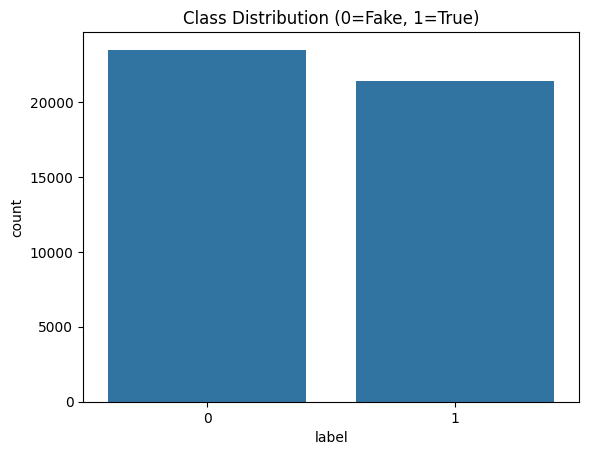

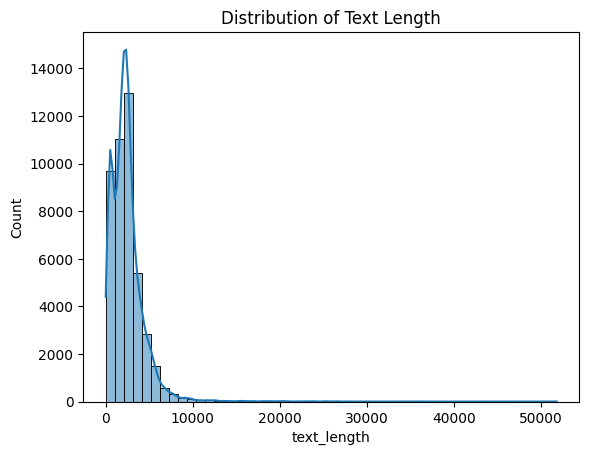

Example fake news article:
title     Donald Trump Sends Out Embarrassing New Year’...
text     Donald Trump just couldn t wish all Americans ...
Name: 0, dtype: object

Example real news article:
title    As U.S. budget fight looms, Republicans flip t...
text     WASHINGTON (Reuters) - The head of a conservat...
Name: 0, dtype: object


In [3]:
print('Class distribution:')
print(data['label'].value_counts())
sns.countplot(x='label', data=data)
plt.title('Class Distribution (0=Fake, 1=True)')
plt.show()

data['text_length'] = data['text'].apply(len)
sns.histplot(data['text_length'], bins=50, kde=True)
plt.title('Distribution of Text Length')
plt.show()

print('Example fake news article:')
print(fake.iloc[0][['title', 'text']])
print('\nExample real news article:')
print(true.iloc[0][['title', 'text']])

# Data Cleaning and Handling Missing Values
    - Check for missing values
    - Remove rows with missing title or text

In [4]:
print('Missing values per column:')
print(data.isnull().sum())
data.dropna(subset=['title', 'text'], inplace=True)

Missing values per column:
title          0
text           0
subject        0
date           0
label          0
text_length    0
dtype: int64


# Handling Outliers
    - Cap text length at 5000 to reduce the effect of extreme outliers

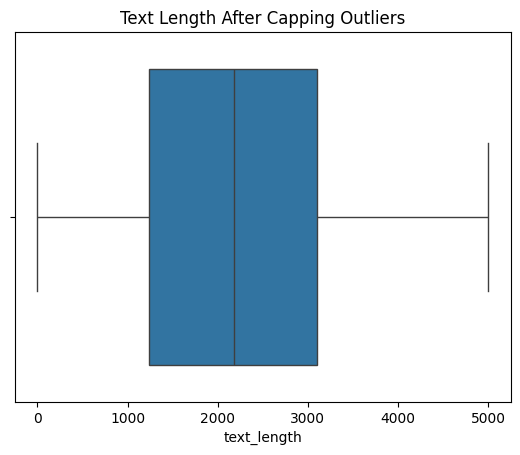

In [5]:
data['text_length'] = np.clip(data['text_length'], 0, 5000)
sns.boxplot(x=data['text_length'])
plt.title('Text Length After Capping Outliers')
plt.show()

# Normalization and Standardization
    - TF-IDF inherently scales features, so additional normalization is not required for text features
    - No further normalization needed

# Train/Test Split

In [6]:
X = data[['title', 'text']]
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Feature Extraction: TF-IDF on Title and Text
    - Fit TF-IDF on both title and text, then concatenate features
Use fewer features, remove stopwords, and ignore very rare/common terms

In [8]:
from sklearn.feature_selection import SelectKBest, chi2

tfidf_title = TfidfVectorizer(
    max_features=100,           # Lowered from 500
    stop_words='english',
    min_df=3,                  # Ignore very rare words
    max_df=0.90                # Ignore overly common words
)
tfidf_text = TfidfVectorizer(
    max_features=500,          # Lowered from 5000
    stop_words='english',
    min_df=3,
    max_df=0.90
)

X_train_title = tfidf_title.fit_transform(X_train['title'])
X_train_text = tfidf_text.fit_transform(X_train['text'])
X_test_title = tfidf_title.transform(X_test['title'])
X_test_text = tfidf_text.transform(X_test['text'])

from scipy.sparse import hstack
X_train_combined = hstack([X_train_title, X_train_text])
X_test_combined = hstack([X_test_title, X_test_text])

# Optional: Feature selection (keep only the most informative features)
# Uncomment below to use feature selection
# selector = SelectKBest(chi2, k=300)
# X_train_combined = selector.fit_transform(X_train_combined, y_train)
# X_test_combined = selector.transform(X_test_combined)

# Models

In [9]:
# Model 1: Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train_combined, y_train)
y_pred_logreg = logreg.predict(X_test_combined)
y_proba_logreg = logreg.predict_proba(X_test_combined)[:, 1]

# Model 2: Multinomial Naive Bayes
nb = MultinomialNB()
nb.fit(X_train_combined, y_train)
y_pred_nb = nb.predict(X_test_combined)
y_proba_nb = nb.predict_proba(X_test_combined)[:, 1]

# Model 3: Random Forest Classifier (with hyperparameter tuning for overfitting)
# Tune max_depth and min_samples_leaf to reduce overfitting
# Make Random Forest even more conservative to avoid overfitting
rf = RandomForestClassifier(
    n_estimators=50,           # Fewer trees
    max_depth=15,              # Lower max depth
    min_samples_leaf=30,       # Larger leaves
    max_features='sqrt',       # Use sqrt(features) at each split
    random_state=42
)
rf.fit(X_train_combined, y_train)
y_pred_rf = rf.predict(X_test_combined)
y_proba_rf = rf.predict_proba(X_test_combined)[:, 1]

# Cross-Validation for All Models (to check for overfitting)

In [10]:
from sklearn.model_selection import cross_val_score

print('\nCross-validation scores (5-fold, accuracy):')
cv_logreg = cross_val_score(logreg, X_train_combined, y_train, cv=5, scoring='accuracy')
cv_nb = cross_val_score(nb, X_train_combined, y_train, cv=5, scoring='accuracy')
cv_rf = cross_val_score(rf, X_train_combined, y_train, cv=5, scoring='accuracy')
print(f'Logistic Regression: {cv_logreg.mean():.4f} ± {cv_logreg.std():.4f}')
print(f'Multinomial Naive Bayes: {cv_nb.mean():.4f} ± {cv_nb.std():.4f}')
print(f'Random Forest: {cv_rf.mean():.4f} ± {cv_rf.std():.4f}')
# Compare with test accuracy below.


Cross-validation scores (5-fold, accuracy):
Logistic Regression: 0.9857 ± 0.0014
Multinomial Naive Bayes: 0.9291 ± 0.0026
Random Forest: 0.9943 ± 0.0006


# Evaluation Function
    - Print classification report, confusion matrix, accuracy, ROC AUC, and plot ROC curve

In [11]:
def evaluate_model(name, y_true, y_pred, y_proba):
    print(f'\n--- {name} ---')
    print('Accuracy:', accuracy_score(y_true, y_pred))
    print('Classification Report:\n', classification_report(y_true, y_pred))
    print('Confusion Matrix:\n', confusion_matrix(y_true, y_pred))
    roc_auc = roc_auc_score(y_true, y_proba)
    print('ROC AUC:', roc_auc)
    fpr, tpr, _ = roc_curve(y_true, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc_auc:.2f})')

# Compare All Models


--- Logistic Regression ---
Accuracy: 0.9848552338530067
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.99      4696
           1       0.98      0.99      0.98      4284

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980

Confusion Matrix:
 [[4616   80]
 [  56 4228]]
ROC AUC: 0.9989124979918145

--- Multinomial Naive Bayes ---
Accuracy: 0.9315144766146993
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.93      0.93      4696
           1       0.92      0.93      0.93      4284

    accuracy                           0.93      8980
   macro avg       0.93      0.93      0.93      8980
weighted avg       0.93      0.93      0.93      8980

Confusion Matrix:
 [[4368  328]
 [ 287 3997]]
ROC AUC: 0.9804363468840119

--- Random Forest ---
Accurac

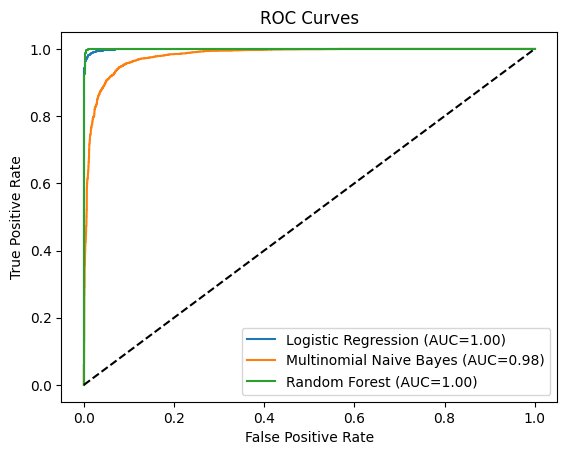

In [12]:
evaluate_model('Logistic Regression', y_test, y_pred_logreg, y_proba_logreg)
evaluate_model('Multinomial Naive Bayes', y_test, y_pred_nb, y_proba_nb)
evaluate_model('Random Forest', y_test, y_pred_rf, y_proba_rf)

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

---------------------------------------------------------
# Analysis of the Findings
---------------------------------------------------------
- Logistic Regression, Multinomial Naive Bayes, and Random Forest are compared.
- Discuss which model performed best and possible reasons (e.g., text data properties, overfitting, etc.).
- Consider trade-offs: interpretability (LogReg), speed (NB), accuracy (RF), etc.
- Note any bias or limitations observed in the results.

---------------------------------------------------------
# Additional Testing for All Models
- Test several custom news articles (realistic and fake)

In [13]:
custom_tests = [
    {
        'title': 'Secret Government Program Controls Weather Using Hidden Satellites',
        'text': 'Sources within the intelligence community have revealed that the government has been operating a classified weather control program since 1997. Using a network of specialized satellites equipped with high-energy frequency transmitters, government agencies can create or prevent rainfall, generate storms, and even trigger earthquakes in targeted regions. This technology was reportedly used to create Hurricane Katrina and more recently to cause drought conditions in agricultural regions of competing nations. Several former military personnel have come forward confirming the existence of this program, code-named "CLIMATE SHIELD," but mainstream media refuses to report on these revelations.'
    },
    {
        'title': 'NASA Announces Discovery of Water on Mars',
        'text': 'In a historic announcement, NASA scientists have confirmed the presence of liquid water on Mars. This discovery opens new possibilities for future manned missions and the search for extraterrestrial life.'
    },
    {
        'title': 'Aliens Land in Central Park, Demand Pizza',
        'text': 'Eyewitnesses claim that a group of aliens landed a spaceship in New York’s Central Park and demanded pizza before returning to their home planet.'
    },
    {
        'title': 'Global Markets Rally After Positive Economic Data',
        'text': 'Stock markets worldwide rallied today after new economic data showed stronger-than-expected job growth and consumer spending.'
    },
    {
        'title': 'Cure for Common Cold Found in Amazon Rainforest',
        'text': 'Researchers claim to have discovered a rare plant in the Amazon rainforest whose extract cures the common cold instantly. However, the scientific community remains skeptical.'
    }
]

for i, test in enumerate(custom_tests):
    print(f"\nCustom Test Case {i+1}:")
    print("Title:", test['title'])
    print("Text:", test['text'][:100] + '...')
    test_df = pd.DataFrame({'title': [test['title']], 'text': [test['text']]})
    test_title = tfidf_title.transform(test_df['title'])
    test_text = tfidf_text.transform(test_df['text'])
    test_combined = hstack([test_title, test_text])
    pred_logreg = logreg.predict(test_combined)[0]
    proba_logreg = logreg.predict_proba(test_combined)[0][1]
    pred_nb = nb.predict(test_combined)[0]
    proba_nb = nb.predict_proba(test_combined)[0][1]
    pred_rf = rf.predict(test_combined)[0]
    proba_rf = rf.predict_proba(test_combined)[0][1]
    print(f"Logistic Regression: {'Real' if pred_logreg else 'Fake'} (Prob Real: {proba_logreg*100:.2f}%)")
    print(f"Naive Bayes: {'Real' if pred_nb else 'Fake'} (Prob Real: {proba_nb*100:.2f}%)")
    print(f"Random Forest: {'Real' if pred_rf else 'Fake'} (Prob Real: {proba_rf*100:.2f}%)")


Custom Test Case 1:
Title: Secret Government Program Controls Weather Using Hidden Satellites
Text: Sources within the intelligence community have revealed that the government has been operating a cla...
Logistic Regression: Fake (Prob Real: 8.11%)
Naive Bayes: Real (Prob Real: 78.16%)
Random Forest: Fake (Prob Real: 23.62%)

Custom Test Case 2:
Title: NASA Announces Discovery of Water on Mars
Text: In a historic announcement, NASA scientists have confirmed the presence of liquid water on Mars. Thi...
Logistic Regression: Fake (Prob Real: 11.80%)
Naive Bayes: Fake (Prob Real: 41.58%)
Random Forest: Fake (Prob Real: 18.99%)

Custom Test Case 3:
Title: Aliens Land in Central Park, Demand Pizza
Text: Eyewitnesses claim that a group of aliens landed a spaceship in New York’s Central Park and demanded...
Logistic Regression: Fake (Prob Real: 33.21%)
Naive Bayes: Real (Prob Real: 54.00%)
Random Forest: Fake (Prob Real: 18.97%)

Custom Test Case 4:
Title: Global Markets Rally After Positive 